# GANs Implementation for Dummy Difficulty Levels


## 0. Dummy Data Creation

In [1]:
# import all the libraries
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import random
import numpy as np

In [2]:
# Set seed for reproducibility
random.seed(42)
sr = [random.uniform(0.3, 1) for _ in range(200)]
round1 = [random.uniform(2.5, 3) for _ in range(200)]

In [3]:
# define a function for successful rate

def f(x):
    return np.sin(math.pi * (x - 0.5))

def round_to_nearest_half(number):
    return round(number * 2) / 2

Due to the age and injury situation, the player initiate difficulty level set as 2.5-3. The first round successful rate are generated randomly, while the following will be generated based on the difficulty level. 

In [4]:
round_1=np.vectorize(round_to_nearest_half)(np.array(round1))
sr_1=np.array(sr)

In [5]:
round_2=np.vectorize(round_to_nearest_half)(round_1+f(sr_1))
sr_2=sr_1-(round_2-round_1)*0.6

round_3=np.vectorize(round_to_nearest_half)(round_2+f(sr_2))
sr_3=sr_2-(round_3-round_2)*0.6

round_4=np.vectorize(round_to_nearest_half)(round_3+f(sr_3))
sr_4=sr_3-(round_4-round_3)*0.6

round_5=np.vectorize(round_to_nearest_half)(round_4+f(sr_4))

In [6]:
train = pd.DataFrame({
    'Round_1': round_1,
    'Round_2': round_2,
    'Round_3': round_3,
    'Round_4': round_4,
    'Round_5': round_5})

## 1. Scenarios and Data
The data was generated from ChatGpt. Assuming the data were generated under the scenario: 2 men played a serious game in arm injury in a recovering period. The game difficulty levels are from 1 to 5. Five rounds will be 1 session. There were 200 sessions in total (1000 rounds). Also, assume the 2 players' heights are 173cm and 175cm, weights are 60kg and 58kg.

#import the dataframe
train = pd.read_excel(r'C:\Users\16468\Desktop\new paper\DUMMY.xlsx',header=None)
train = pd.DataFrame(train.values.reshape(80, 5), columns=['round_1', 'round_2', 'round_3','round_4','round_5'])

In [7]:
# check the data
train

,Round_1,Round_2,Round_3,Round_4,Round_5
0,3.0,3.5,3.5,3.5,3.5
1,3.0,2.5,3.0,2.5,3.0
2,3.0,3.0,3.0,3.0,3.0
3,2.5,2.5,2.5,2.5,2.5
4,2.5,3.5,2.5,3.5,2.5
...,...,...,...,...,...
195,2.5,3.5,3.0,3.5,3.0
196,2.5,3.0,2.5,3.0,2.5
197,3.0,2.5,3.0,2.5,3.0
198,3.0,4.0,3.5,4.0,3.5


In [8]:
train.describe()

,Round_1,Round_2,Round_3,Round_4,Round_5
count,200.000000,200.000000,200.00000,200.000000,200.00000
mean,2.765000,3.117500,2.92500,3.090000,2.92500
std,0.250176,0.601459,0.36059,0.579724,0.36059
min,2.500000,2.000000,2.50000,2.000000,2.50000
25%,2.500000,2.500000,2.50000,2.500000,2.50000
50%,3.000000,3.000000,3.00000,3.000000,3.00000
75%,3.000000,3.500000,3.00000,3.500000,3.00000
max,3.000000,4.000000,3.50000,4.000000,3.50000


The average data of each round is listed as 2.77, 3.12, 2.93, 3.09, 2.93. We are going to plot the data to see the general trend of difficulty levels for the 5 rounds. 

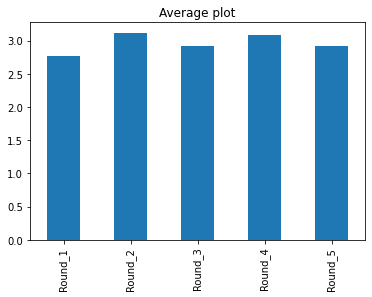

In [22]:
# plot the average
avgs = train.mean()
plot = avgs.plot(kind='bar',title="Average plot")

Ramdomly selected 5 session to plot the trend of each session.

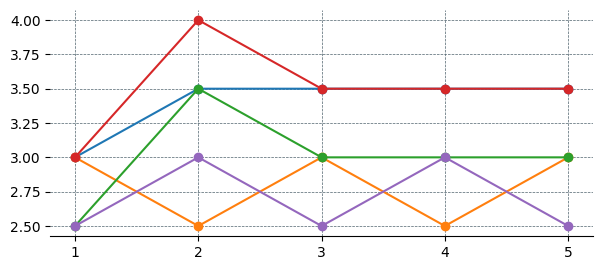

In [10]:
# plot the 5 sessions on the same plot
fig, ax = plt.subplots(figsize = (7,3), dpi = 100)

Y_1 = train.iloc[0,:]
Y_2 = train.iloc[9,:]
Y_3 = train.iloc[18,:]
Y_4 = train.iloc[20,:]
Y_5 = train.iloc[35,:]
X_ = [1,2,3,4,5]
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Remove spines and add gridlines
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid(ls = "--", lw = 0.5, color = "#4E616C")

# Plot
ax.plot(X_, Y_1, marker = "o")
ax.plot(X_, Y_2, marker = "o")
ax.plot(X_, Y_3, marker = "o")
ax.plot(X_, Y_4, marker = "o")
ax.plot(X_, Y_5, marker = "o")

## 2. GANs Generator Set-up

As the data of each session got 5 difficulty levels, therefore, the generator should have 5 elements as output. Now we would like to set the input of the generator includes 4 elements, which are height, weight, injury level and gender.

In [11]:
# Discriminator and Generator submodels
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(250, 125),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(125, 25),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(25, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output   
    
discriminator = Discriminator()

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 25),
            nn.Sigmoid(),
            nn.Linear(25, 50),
            nn.Sigmoid(),
            nn.Linear(50, 125),
            nn.Sigmoid(),
            nn.Linear(125, 250),
            nn.Sigmoid(),
            nn.Linear(250, 125),
            nn.Sigmoid(),
            nn.Linear(125, 50),
            nn.ReLU(),
            nn.Linear(50, 5),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

## 3. Data Preparation and Model Training

While training the model, the training data shoule be loaded in the stand-by status as a tensor. The label of the real data (training data) will be labeled as 0 for the discriminator step training. 

In [12]:
# Create the training tensor
train_data = torch.tensor(train.iloc[:,:].values).to(torch.float32)
# Create the zero labels for the real data
train_labels = torch.zeros(200)
train_set = [(train_data[i], train_labels[i]) for i in range(200)]

In [13]:
# set the training batch size as 10
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# tuning the parameters of the neural networks
lr = 0.001
num_epochs = 400
#loss_function = nn.BCEWithLogitsLoss()
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCELoss()


optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

#### It is important to determine the NOISES.
As we would like to generate the same pattern of future 5 rounds for the people with the similar situation, including the information of height, weight, gender as well as the injury status, the "noises" should be set as the specific range of data. Here, we are going to create some "noises" with height in range 1.70-1.75m, weight in range 5.5-6.5 (*10kg), injury status in level 2 and 3, gender only for male, indicate as 1.

The fake data will start with the "noises" and the data will be trained for those players with "noises" in that range

In [14]:
a=[[1.73,5.6,2],[1.70,6.1,3],[1.72,5.5,2],[1.72,5.8,2],[1.72,5.6,2],
   [1.75,5.8,3],[1.71,6.2,2],[1.70,6.2,2],[1.71,6.3,3],[1.75,6.3,3],
   [1.70,5.5,2],[1.72,6.3,3],[1.72,6.5,3],[1.73,6.1,2],[1.72,6.2,2],
   [1.72,5.6,3],[1.73,6.2,2],[1.71,5.6,2],[1.70,5.9,3],[1.72,5.9,2],
   [1.74,5.9,2],[1.74,6.5,3],[1.75,5.7,3],[1.73,6.3,2],[1.74,5.9,3],
   [1.73,6.5,3],[1.75,5.9,2],[1.70,6.3,2],[1.71,5.6,3],[1.73,6.1,2]]

In [15]:
ran=random.sample(a, 4)

In [16]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        
        # THE NOISES
        latent_space_samples = torch.tensor(ran).to(torch.float32)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.tensor(ran).to(torch.float32)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        #if epoch % 10 == 0 and n == batch_size-1:
    print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
    print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.8817592859268188
Epoch: 0 Loss G.: 1.057128667831421
Epoch: 1 Loss D.: 0.31121429800987244
Epoch: 1 Loss G.: 2.324512243270874
Epoch: 2 Loss D.: 0.054445862770080566
Epoch: 2 Loss G.: 3.0452213287353516
Epoch: 3 Loss D.: 1.8014451265335083
Epoch: 3 Loss G.: 1.9000482559204102
Epoch: 4 Loss D.: 0.46507591009140015
Epoch: 4 Loss G.: 1.169417142868042
Epoch: 5 Loss D.: 0.7105437517166138
Epoch: 5 Loss G.: 1.3256044387817383
Epoch: 6 Loss D.: 0.5206009149551392
Epoch: 6 Loss G.: 1.050935983657837
Epoch: 7 Loss D.: 0.2952547073364258
Epoch: 7 Loss G.: 1.1414798498153687
Epoch: 8 Loss D.: 0.5562657713890076
Epoch: 8 Loss G.: 0.9901743531227112
Epoch: 9 Loss D.: 0.42587095499038696
Epoch: 9 Loss G.: 1.2002183198928833
Epoch: 10 Loss D.: 0.5892791748046875
Epoch: 10 Loss G.: 0.8371881246566772
Epoch: 11 Loss D.: 0.9835265874862671
Epoch: 11 Loss G.: 0.5355060696601868
Epoch: 12 Loss D.: 0.5874110460281372
Epoch: 12 Loss G.: 0.712553083896637
Epoch: 13 Loss D.: 0.68267500400

Epoch: 108 Loss D.: 0.6930073499679565
Epoch: 108 Loss G.: 2.4312500953674316
Epoch: 109 Loss D.: 0.49821197986602783
Epoch: 109 Loss G.: 1.514195203781128
Epoch: 110 Loss D.: 0.3988769054412842
Epoch: 110 Loss G.: 2.2149112224578857
Epoch: 111 Loss D.: 0.16989469528198242
Epoch: 111 Loss G.: 1.7115731239318848
Epoch: 112 Loss D.: 0.1014571413397789
Epoch: 112 Loss G.: 2.359795093536377
Epoch: 113 Loss D.: 1.0119372606277466
Epoch: 113 Loss G.: 1.5952825546264648
Epoch: 114 Loss D.: 0.4423041343688965
Epoch: 114 Loss G.: 1.6887800693511963
Epoch: 115 Loss D.: 0.22594913840293884
Epoch: 115 Loss G.: 1.5530797243118286
Epoch: 116 Loss D.: 0.16223889589309692
Epoch: 116 Loss G.: 1.5941495895385742
Epoch: 117 Loss D.: 1.6992676258087158
Epoch: 117 Loss G.: 2.3157458305358887
Epoch: 118 Loss D.: 0.04899071156978607
Epoch: 118 Loss G.: 2.6888461112976074
Epoch: 119 Loss D.: 0.08586962521076202
Epoch: 119 Loss G.: 1.842142939567566
Epoch: 120 Loss D.: 0.5205092430114746
Epoch: 120 Loss G.: 2.

Epoch: 213 Loss D.: 0.2504633963108063
Epoch: 213 Loss G.: 1.5664315223693848
Epoch: 214 Loss D.: 1.1670210361480713
Epoch: 214 Loss G.: 1.0071940422058105
Epoch: 215 Loss D.: 0.29880696535110474
Epoch: 215 Loss G.: 2.124023914337158
Epoch: 216 Loss D.: 0.671859085559845
Epoch: 216 Loss G.: 1.5214900970458984
Epoch: 217 Loss D.: 0.3325408697128296
Epoch: 217 Loss G.: 1.4814258813858032
Epoch: 218 Loss D.: 0.29954493045806885
Epoch: 218 Loss G.: 1.4225696325302124
Epoch: 219 Loss D.: 0.32247596979141235
Epoch: 219 Loss G.: 1.4713199138641357
Epoch: 220 Loss D.: 0.3321814239025116
Epoch: 220 Loss G.: 1.5427610874176025
Epoch: 221 Loss D.: 0.29907745122909546
Epoch: 221 Loss G.: 1.5865259170532227
Epoch: 222 Loss D.: 0.4579288363456726
Epoch: 222 Loss G.: 1.5649290084838867
Epoch: 223 Loss D.: 0.5545864701271057
Epoch: 223 Loss G.: 1.4660489559173584
Epoch: 224 Loss D.: 0.11795321106910706
Epoch: 224 Loss G.: 1.5744014978408813
Epoch: 225 Loss D.: 0.11237404495477676
Epoch: 225 Loss G.: 1

Epoch: 318 Loss D.: 0.4864750802516937
Epoch: 318 Loss G.: 1.4971686601638794
Epoch: 319 Loss D.: 0.3033768832683563
Epoch: 319 Loss G.: 1.6018431186676025
Epoch: 320 Loss D.: 0.3164648711681366
Epoch: 320 Loss G.: 1.5447648763656616
Epoch: 321 Loss D.: 0.3364444971084595
Epoch: 321 Loss G.: 1.5806970596313477
Epoch: 322 Loss D.: 0.526688814163208
Epoch: 322 Loss G.: 1.4422643184661865
Epoch: 323 Loss D.: 0.11666639149188995
Epoch: 323 Loss G.: 1.585079550743103
Epoch: 324 Loss D.: 0.3010018467903137
Epoch: 324 Loss G.: 1.7900031805038452
Epoch: 325 Loss D.: 0.32665637135505676
Epoch: 325 Loss G.: 1.5279542207717896
Epoch: 326 Loss D.: 0.3094983398914337
Epoch: 326 Loss G.: 1.6429085731506348
Epoch: 327 Loss D.: 0.5168351531028748
Epoch: 327 Loss G.: 1.6867876052856445
Epoch: 328 Loss D.: 0.1321200728416443
Epoch: 328 Loss G.: 1.471522331237793
Epoch: 329 Loss D.: 0.48992225527763367
Epoch: 329 Loss G.: 1.5930204391479492
Epoch: 330 Loss D.: 0.11054416000843048
Epoch: 330 Loss G.: 1.62

# 4. Result Testing

We are going to use some "noises" within the ranges for the GANs model and create some samples to see the trend of the 5 rounds of difficulty levels, and check the plot to see how different it is from the real data.

In [17]:
# input of noises and generate difficulty levels
latent_space_samples = torch.tensor([[1.75,5.6,2], [1.76,6.0,3],[1.75,6.5,2],[1.70,6.3,3],[1.74,6.2,2]]).to(torch.float32)
generated_samples = torch.round(generator(latent_space_samples),decimals=1)

In [18]:
# The 5 generated results.
generated_samples

tensor([[2.7000, 3.1000, 3.1000, 3.2000, 3.1000],
        [2.7000, 3.1000, 3.1000, 3.2000, 3.1000],
        [2.7000, 3.1000, 3.1000, 3.2000, 3.1000],
        [2.7000, 3.1000, 3.1000, 3.2000, 3.1000],
        [2.7000, 3.1000, 3.1000, 3.2000, 3.1000]], grad_fn=<RoundBackward1>)

In [19]:
px = pd.DataFrame(generated_samples.detach().numpy()).astype("float")

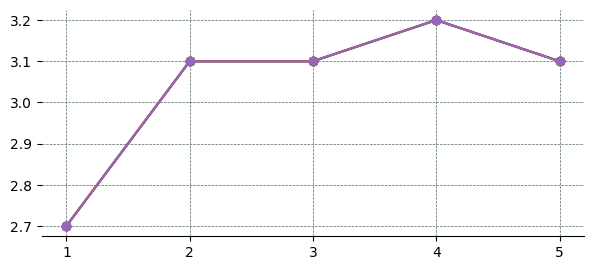

In [20]:
fig, ax = plt.subplots(figsize = (7,3), dpi = 100)

Y_1 = px.iloc[0,:]
Y_2 = px.iloc[1,:]
Y_3 = px.iloc[2,:]
Y_4 = px.iloc[3,:]
Y_5 = px.iloc[4,:]
X_ = [1,2,3,4,5]
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# --- Remove spines and add gridlines
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls = "--", lw = 0.5, color = "#4E616C")

# --- The data
ax.plot(X_, Y_1, marker = "o")
ax.plot(X_, Y_2, marker = "o")
ax.plot(X_, Y_3, marker = "o")
ax.plot(X_, Y_4, marker = "o")
ax.plot(X_, Y_5, marker = "o")

In [23]:
avgs2 = px.mean()
avgs2

0    2.7
1    3.1
2    3.1
3    3.2
4    3.1
dtype: float64

The average data of each round is listed as 2.60, 4.04, 2.10, 3.46, 4.42. We are going to plot the generated data to see the general trend of difficulty levels for the immitation 5 rounds.

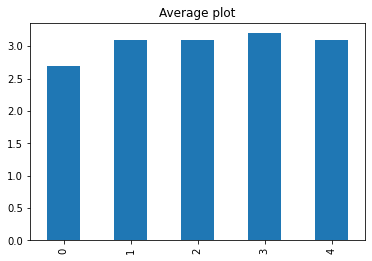

In [24]:
plot = avgs2.plot(kind='bar',title="Average plot")

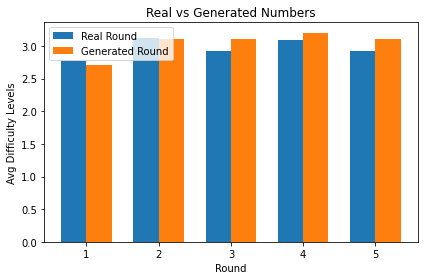

In [31]:

bar_width = 0.35
x=np.array([1,2,3,4,5])
# Plotting
plt.bar(x - bar_width/2, avgs, bar_width, label='Real Round')
plt.bar(x + bar_width/2, avgs2, bar_width, label='Generated Round')

# Add labels, title, and legend
plt.xlabel('Round')
plt.ylabel('Avg Difficulty Levels')
plt.title('Real vs Generated Numbers')
plt.xticks(x, x)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()